<a href="https://colab.research.google.com/github/kumuthuraman/ITCS6156-OpenProject/blob/main/OpenProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
---
---
---

In [ ]:
import os
import cv2
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlretrieve
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy

In [ ]:
try:
  with open('/content/dataset.ndjson', 'r') as f:
    labelbox_data = []
    for line in f:
      try:
        labelbox_data.append(json.loads(line.strip()))  # Strip leading/trailing whitespace
      except json.JSONDecodeError:
        print(f"Error decoding line: {line}")
        # Handle or skip the line with the error

  print("Successfully loaded JSON data!")
except FileNotFoundError:
  print("File not found!")

# # Debugging print statements
# # Process labelbox_data (list containing each valid JSON object)
# print(labelbox_data[0])

Successfully loaded JSON data!


In [ ]:
image_data = []
# labels = []
character_labels = []
show_labels = []

for item in labelbox_data:
  # Access image data (URL or path)
  image_url = item['data_row']['row_data']  # Assuming this points to the image

  # Extract labels (name and show name)
  annotations = item['projects']['clvdt0s7p00is073l636f34ag']['labels'][0]['annotations']
  character_name = annotations['objects'][0]['name']  # "kai smith"
  show_name = annotations['classifications'][0]['radio_answer']['value']  # "ninjago"

  # Combine and append data and labels
  # Append data and labels
  image_data.append(image_url)
  character_labels.append(character_name)
  show_labels.append(show_name)

# # Debugging print statements
# print(image_data[:5])
# print(character_labels[:5])
# print(show_labels[:5])

In [ ]:
# Split data and labels with a test size of 0.3 (30% for validation)
train_image_data, val_image_data, train_character_labels, val_character_labels, train_show_labels, val_show_labels = train_test_split(image_data, character_labels, show_labels, test_size=0.3, random_state=42)

In [ ]:
# Create train and validation directories
train_dir = 'train'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

val_dir = 'val'
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

def crop_image(image_path):
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnt = contours[0]
  x,y,w,h = cv2.boundingRect(cnt)
  crop = img[y:y+h,x:x+w]
  cv2.imwrite(image_path,crop)

def download_and_preprocess_image(image_url, label_name, category_dir, index):
  filename = f"{category_dir}/{label_name.replace(' ', '_')}_{index}.jpg"  # Simplified filename
  urlretrieve(image_url, filename)

  crop_image(filename)

  # Load image using PIL
  image = Image.open(filename).convert('RGB')
  # Resize image to desired size
  image = image.resize((224, 224))
  # Convert image to numpy array
  image_array = np.array(image)
  # Normalize pixel values (optional, might not be necessary depending on pre-trained model)
  # image_array = image_array / 255.0
  return image_array

In [ ]:
train_images = []
val_images = []

# Create label encoder objects
character_label_encoder = LabelEncoder()
show_label_encoder = LabelEncoder()

# Fit label encoders and transform labels to integers
train_character_labels_encoded = to_categorical(character_label_encoder.fit_transform(train_character_labels))
train_show_labels_encoded = to_categorical(show_label_encoder.fit_transform(train_show_labels))
val_character_labels_encoded = to_categorical(character_label_encoder.fit_transform(val_character_labels))
val_show_labels_encoded = to_categorical(show_label_encoder.fit_transform(val_show_labels))

# Download and preprocess training images
for i, image_url in enumerate(train_image_data):
  train_image = download_and_preprocess_image(image_url, train_character_labels[i], train_dir, i)
  train_images.append(train_image)

# Download and preprocess validation images (similar loop with adjustments)
for i, image_url in enumerate(val_image_data):
  val_image = download_and_preprocess_image(image_url, val_character_labels[i], val_dir, i)
  val_images.append(val_image)

In [ ]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)

# # Debugging print statements
# print(train_images.shape) # (35, 224, 224, 3)
# print(train_character_labels_encoded.shape) # (35, 4)
# print(train_show_labels_encoded.shape) # (35, 2)
# print(val_images.shape) # (9, 224, 224, 3)
# print(val_character_labels_encoded.shape) # (9, 4)
# print(val_show_labels_encoded.shape) # (9, 2)

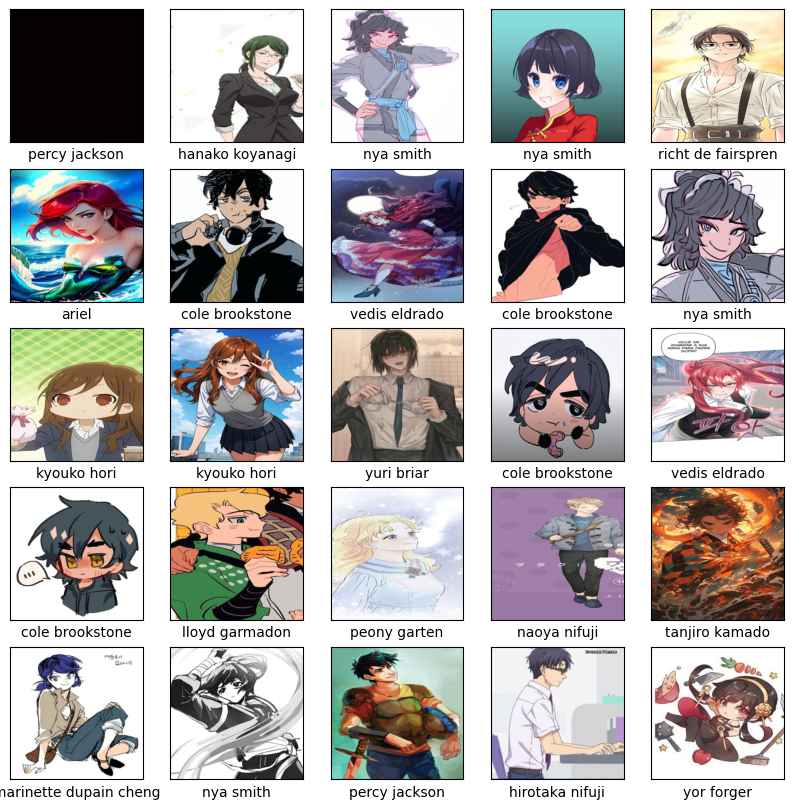

In [ ]:
# # Debugging dataset statements

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # plt.imshow(train_image_data[i])
    # Load image using PIL
    # image = Image.open(train_image_data[i])
    image = train_images[i]
    # Convert image to numpy array
    image_array = np.array(image)
    # train_images.append(image)
    # Display image
    plt.imshow(image_array)

    plt.xlabel(train_character_labels[i])  # Display character name as class name
plt.show()

In [ ]:
# Define ResNet50 model (pre-trained with ImageNet weights)
# Include top layer (False) as we'll add our own classification head
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze base model layers (optional, can be fine-tuned later)
# base_model.trainable = False

# Add custom classification head for multiple labels
x = base_model.output
x = Flatten()(x)  # Flatten features from base model
x = Dropout(0.2)(x)  # Add Dropout for regularization

x_character = Dense(len(set(character_labels)), activation='softmax')(x)  # Character classification output
x = Dropout(0.2)(x)  # Add Dropout for regularization
x_show = Dense(len(set(show_labels)), activation='softmax')(x)  # Show/series classification output

# Unfreeze a few top layers for fine-tuning (adjust number of layers as needed)
for layer in base_model.layers[-10:]:
  layer.trainable = True

# Combine outputs for training (assuming separate losses for each)
model = Model(inputs=base_model.input, outputs=[x_character, x_show])

# Define optimizer, loss functions, and compile the model (adapt based on your needs)
optimizer = Adam(learning_rate=0.001)
loss_fn = [categorical_crossentropy, categorical_crossentropy]  # Separate losses for each output

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Train the model (replace with your training parameters)
model.fit(
    train_images,
    [train_character_labels_encoded, train_show_labels_encoded],  # Separate label lists for multi-output model
    epochs=15,
    batch_size=32,
    validation_data=(val_images, [val_character_labels_encoded, val_show_labels_encoded])
)

Epoch 1/15
7/7 [==============================] - 200s 25s/step - loss: 31.3290 - dense_loss: 13.7890 - dense_1_loss: 17.5400 - dense_accuracy: 0.1190 - dense_1_accuracy: 0.1810 - val_loss: 56.9118 - val_dense_loss: 32.1255 - val_dense_1_loss: 24.7862 - val_dense_accuracy: 0.0330 - val_dense_1_accuracy: 0.2088
Epoch 2/15
7/7 [==============================] - 176s 25s/step - loss: 8.0072 - dense_loss: 4.5783 - dense_1_loss: 3.4290 - dense_accuracy: 0.7143 - dense_1_accuracy: 0.7048 - val_loss: 137.1872 - val_dense_loss: 79.2714 - val_dense_1_loss: 57.9157 - val_dense_accuracy: 0.0220 - val_dense_1_accuracy: 0.0549
Epoch 3/15
7/7 [==============================] - 169s 24s/step - loss: 3.6652 - dense_loss: 2.0300 - dense_1_loss: 1.6352 - dense_accuracy: 0.8143 - dense_1_accuracy: 0.7619 - val_loss: 707.1464 - val_dense_loss: 497.2087 - val_dense_1_loss: 209.9377 - val_dense_accuracy: 0.0440 - val_dense_1_accuracy: 0.1099
Epoch 4/15
7/7 [==============================] - 168s 24s/step - 

1/1 [==============================] - 1s 1s/step
Predicted Character: kai smith
Predicted Show: straight to the red carpet


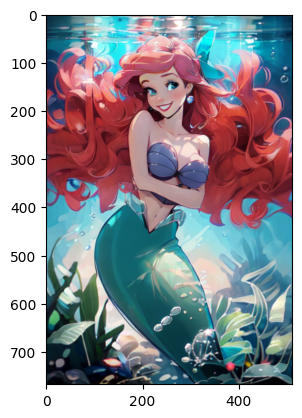

In [ ]:
def preprocess_image(image_url):
  # filename = "new_image.jpg"  # Temporary filename
  # urlretrieve(image_url, filename)
  image = Image.open(image_url).convert('RGB')
  image = image.resize((224, 224))
  image_array = np.array(image)
  # Optional normalization (divide by 255.0 if needed)
  return image_array

new_image_url = "/content/ariel_the_little_mermaid_008.webp"  # Replace with image URL
preprocessed_image = preprocess_image(new_image_url)
predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

character_index = np.argmax(predictions[0])
character_label = character_label_encoder.inverse_transform([character_index])[0]

show_index = np.argmax(predictions[1])
show_label = show_label_encoder.inverse_transform([show_index])[0]


print(f"Predicted Character: {character_label}")
print(f"Predicted Show: {show_label}")

plt.imshow(np.array(Image.open(new_image_url)))
plt.show()

1/1 [==============================] - 0s 191ms/step
Predicted Character: kai smith
Predicted Show: the little mermaid


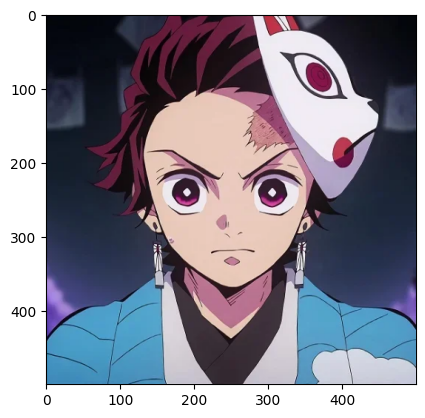

In [ ]:
new_image_url = "/content/tanjiro_kamado_demon_slayer_010.jpg"  # Replace with your image URL
preprocessed_image = preprocess_image(new_image_url)
predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

character_index = np.argmax(predictions[0])
character_label = character_label_encoder.inverse_transform([character_index])[0]

show_index = np.argmax(predictions[1])
show_label = show_label_encoder.inverse_transform([show_index])[0]


print(f"Predicted Character: {character_label}")
print(f"Predicted Show: {show_label}")

plt.imshow(np.array(Image.open(new_image_url)))
plt.show()

1/1 [==============================] - 0s 313ms/step
Predicted Character: kai smith
Predicted Show: ninjago


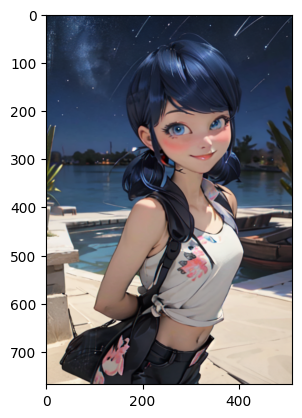

In [ ]:
new_image_url = "/content/marinette_dupain_cheng_miraculous_ladybug_005.webp"  # Replace with your image URL
preprocessed_image = preprocess_image(new_image_url)
predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

character_index = np.argmax(predictions[0])
character_label = character_label_encoder.inverse_transform([character_index])[0]

show_index = np.argmax(predictions[1])
show_label = show_label_encoder.inverse_transform([show_index])[0]


print(f"Predicted Character: {character_label}")
print(f"Predicted Show: {show_label}")

plt.imshow(np.array(Image.open(new_image_url)))
plt.show()

1/1 [==============================] - 0s 372ms/step
Predicted Character: kai smith
Predicted Show: the little mermaid


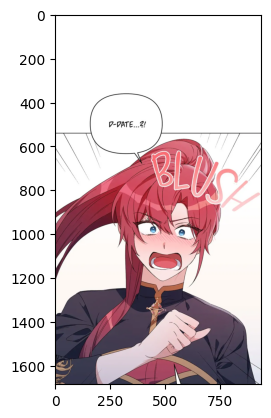

In [ ]:
new_image_url = "/content/vedis_eldrado_straight_to_the_red_carpet_010.jpg"  # Replace with your image URL
preprocessed_image = preprocess_image(new_image_url)
predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

character_index = np.argmax(predictions[0])
character_label = character_label_encoder.inverse_transform([character_index])[0]

show_index = np.argmax(predictions[1])
show_label = show_label_encoder.inverse_transform([show_index])[0]


print(f"Predicted Character: {character_label}")
print(f"Predicted Show: {show_label}")

plt.imshow(np.array(Image.open(new_image_url)))
plt.show()

In [ ]:
# Evaluate the model on validation set

# Overall Accuracy (for each output)
val_loss, val_loss_character, val_loss_show, val_acc_character, val_acc_show = model.evaluate(val_images, [val_character_labels_encoded, val_show_labels_encoded])
print(f"Validation Character Accuracy: {val_acc_character:.4f}")
print(f"Validation Show Accuracy: {val_acc_show:.4f}")

# Precision, Recall, F1-score (using scikit-learn metrics)
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions for validation data (one-hot encoded)
val_preds = model.predict(val_images)

# Decode predictions back to class labels (assuming you kept label encoders)
val_pred_labels_character = character_label_encoder.inverse_transform(np.argmax(val_preds[0], axis=1))
val_true_labels_character = character_label_encoder.inverse_transform(val_character_labels_encoded.argmax(axis=1))

val_pred_labels_show = show_label_encoder.inverse_transform(np.argmax(val_preds[1], axis=1))
val_true_labels_show = show_label_encoder.inverse_transform(val_show_labels_encoded.argmax(axis=1))

# Calculate Precision, Recall, and F1-score for each classification task
precision_character = precision_score(val_true_labels_character, val_pred_labels_character, average='macro')
recall_character = recall_score(val_true_labels_character, val_pred_labels_character, average='macro')
f1_character = f1_score(val_true_labels_character, val_pred_labels_character, average='macro')

precision_show = precision_score(val_true_labels_show, val_pred_labels_show, average='macro')
recall_show = recall_score(val_true_labels_show, val_pred_labels_show, average='macro')
f1_show = f1_score(val_true_labels_show, val_pred_labels_show, average='macro')

print(f"Character Classification:")
print(f"\tPrecision: {precision_character:.4f}")
print(f"\tRecall: {recall_character:.4f}")
print(f"\tF1-score: {f1_character:.4f}")

print(f"Show Classification:")
print(f"\tPrecision: {precision_show:.4f}")
print(f"\tRecall: {recall_show:.4f}")
print(f"\tF1-score: {f1_show:.4f}")

# Confusion Matrix (using scikit-learn metrics)
from sklearn.metrics import confusion_matrix

# Confusion matrix for character classification
cm_character = confusion_matrix(val_true_labels_character, val_pred_labels_character)
print("\nCharacter Classification Confusion Matrix:")
print(cm_character)

# Confusion matrix for show classification
cm_show = confusion_matrix(val_true_labels_show, val_pred_labels_show)
print("\nShow Classification Confusion Matrix:")
print(cm_show)

3/3 [==============================] - 16s 5s/step - loss: 291.9778 - dense_loss: 200.0033 - dense_1_loss: 91.9745 - dense_accuracy: 0.0440 - dense_1_accuracy: 0.1209
Validation Character Accuracy: 0.0440
Validation Show Accuracy: 0.1209
3/3 [==============================] - 21s 7s/step
Character Classification:
	Precision: 0.0122
	Recall: 0.0648
	F1-score: 0.0179
Show Classification:
	Precision: 0.0285
	Recall: 0.1551
	F1-score: 0.0435

Character Classification Confusion Matrix:
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---
---
---
---
---